# are lncRNAs qauntified?

compare read counts to reads in a nearby "null" section of genome to see.

1. aggregate nulls and reads for each tissues
2. get yes/no for each gene if it is quantified in each tissue
3. plot patterns of quantification across tissues

In [3]:
import seaborn as sns
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import os
from scipy import stats
import numpy as np


%config InlineBackend.figure_formats = ['png']
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})

In [4]:
rnaseqc_dir = '/home/klawren/oak/gtex/output/all_tissues/'
null_dir = '/home/klawren/oak/gtex/output/all_tissues_null/v11_intergenic/'

bring in the gtex colors and make a palette

In [5]:
# Load JSON data from a file
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json', 'r') as file:
    tissue_color_data = json.load(file)

# Convert the JSON data to a DataFrame
tissue_color_df = pd.DataFrame.from_dict(tissue_color_data, orient='index')
tissue_color_df.index.set_names('tissue_name', inplace=True)
tissue_color_df.reset_index(inplace=True)
tissue_color_df['tissue_color_hex'] = '#' + tissue_color_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_color_df['tissue_color_hex'])

which samples belong to which tissues and pass qc?

from francois: "use the SMAFRZE column (== ‘RNASEQ’)"

In [6]:
# load in tissue-sample matching
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE']=='RNASEQ']
tissue_sample_lists = passed_samples.groupby('SMTSD').agg({'SAMPID':'unique'})

/local/scratch/klawren/slrmtmp.48466672/ipykernel_4259/682259141.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


/local/scratch/klawren/slrmtmp.48466672/ipykernel_4259/3860355331.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax,


/local/scratch/klawren/slrmtmp.48466672/ipykernel_4259/3860355331.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(tissue_color_df['tissue_abbrv'], fontsize=6)


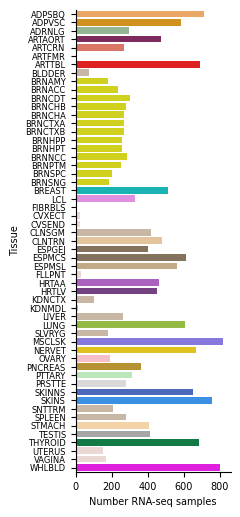

In [7]:
# plot the number of samples in each tissue
fig, ax = plt.subplots(figsize=(2,6))

sns.countplot(ax=ax,
              data=passed_samples, 
              y='SMTSD', 
              order=tissue_color_df['tissue_name'],
              palette=tissue_color_palette)

ax.set_ylabel('Tissue')
ax.set_xlabel('Number RNA-seq samples')
ax.set_yticklabels(tissue_color_df['tissue_abbrv'], fontsize=6)

ax.spines[['top', 'right']].set_visible(False)
plt.show()


For each tissue, aggregate the samples gene counts for the actual genes and the matched null

In [8]:
# aggregate sample level counts to a df
def agg_rnaseqc(output_dir, tissue_sample_ids, file_end='gene_reads'):
    sample_tpms = []
    # get tpms for all samples 
    for sample_id in tqdm(tissue_sample_ids):
        expected_filename = f"{sample_id}.{file_end}.gct.gz"
        file_path = os.path.join(os.path.join(output_dir, 'rnaseq_qc'), expected_filename)
        if os.path.isfile(file_path):
            sample_tpms.append(pd.read_csv(file_path, sep='\t', skiprows=2).set_index(['Name', 'Description']))
        else:
            print(f"File not found: {file_path}")
    tpm_agg = pd.concat(sample_tpms, axis=1).reset_index()
    return tpm_agg


# get null and gene aggreagations (read in if exisitng otherwise create)
def get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id, file_end='gene_reads'):
    print('Processing samples for {}'.format(tissue_id))
    sample_ids = tissue_sample_lists.loc[tissue_id]['SAMPID']
    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')

    gene_agg_path = os.path.join(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), f"{tissue_id_clean}.v11.{file_end}.gct.gz")
    print(f'\t{gene_agg_path}')
    try:
        gene_agg = pd.read_csv(gene_agg_path, sep='\t')
    except FileNotFoundError:
        gene_agg = agg_rnaseqc(rnaseqc_dir, sample_ids, file_end=file_end)
        os.makedirs(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), exist_ok=True)
        gene_agg.to_csv(gene_agg_path, sep='\t', index=False, compression='gzip')

    null_agg_path = os.path.join(os.path.join(null_dir, 'rnaseqc_agg') ,f"{tissue_id_clean}.v11_null.{file_end}.gct.gz")
    print(f'\t{null_agg_path}')
    try:
        null_agg = pd.read_csv(null_agg_path, sep='\t')
    except FileNotFoundError:
        null_agg = agg_rnaseqc(null_dir, sample_ids, file_end=file_end)
        os.makedirs(os.path.join(null_dir, 'rnaseqc_agg'), exist_ok=True)
        null_agg.to_csv(null_agg_path, sep='\t', index=False, compression='gzip')

    # null for mitochondial genes doesn't work, becuase there isn't enough null space on the mitochondiral genome
    print('\tRemoving {} mito genes that dont have matched null'.format(len(gene_agg[~gene_agg['Name'].isin(null_agg['Name'])])))
    gene_agg = gene_agg[gene_agg['Name'].isin(null_agg['Name'])]
    return gene_agg, null_agg

Processing samples for Bladder
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Bladder.v11.gene_reads.gct.gz
	/home/klawren/oak/gtex/output/all_tissues_null/v11_intergenic/rnaseqc_agg/Bladder.v11_null.gene_reads.gct.gz
	Removing 38 mito genes that dont have matched null


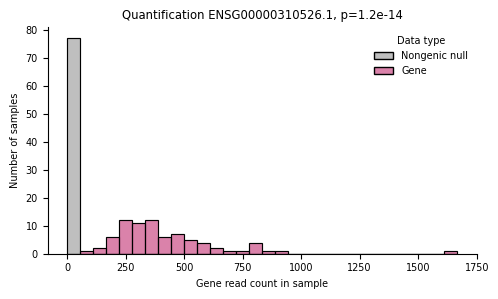

In [9]:
def plot_matched_null(sample_gene_id, gene_agg, null_agg):
    sample_columns = gene_agg.columns[2:]
    null_counts  = null_agg[null_agg['Name']==sample_gene_id][sample_columns].values[0]
    gene_counts  = gene_agg[gene_agg['Name']==sample_gene_id][sample_columns].values[0]
    stat, p_value = stats.wilcoxon(gene_counts, null_counts, alternative='greater')
    # plot the two distributions for a sample gene
    plot_df = pd.DataFrame({
        'count': np.concatenate([null_counts, gene_counts]),
        'distribution': ['Nongenic null'] * len(null_counts) + ['Gene'] * len(gene_counts)})

    fig, ax = plt.subplots(figsize=(5,3))
    if max(gene_counts) > 30:
        sns.histplot(plot_df,x='count', bins=30, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    else:
        sns.histplot(plot_df,x='count', discrete=True, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Gene read count in sample')
    ax.set_ylabel('Number of samples')
    # Customize the legend
    legend = ax.get_legend()
    legend.get_frame().set_visible(False)
    legend.set_title("Data type")
    ax.set_title('Quantification {}, p={:.1e}'.format(sample_gene_id, p_value))
    fig.tight_layout()

gene_agg, null_agg = get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, 'Bladder')
plot_matched_null(gene_agg['Name'].iloc[1], gene_agg, null_agg)

In [10]:
# get p values for the tissue
def get_tissue_pvalues(gene_agg, null_agg):
    print('\tCalculating p values...')

    sample_columns = gene_agg.columns[2:]
    null_counts_array = null_agg.set_index('Name').loc[gene_agg['Name']][sample_columns].values
    gene_counts_array = gene_agg.set_index('Name').loc[gene_agg['Name']][sample_columns].values

    p_values = np.empty(len(gene_agg['Name']))
    median_counts = np.empty(len(gene_agg['Name']))
    mean_counts = np.empty(len(gene_agg['Name']))
    median_null_counts = np.empty(len(gene_agg['Name']))
    mean_null_counts = np.empty(len(gene_agg['Name']))

    for idx in tqdm(range(len(gene_agg['Name'])), total=len(gene_agg['Name'])):
        null_counts = null_counts_array[idx]
        gene_counts = gene_counts_array[idx]
        if np.all(gene_counts == 0) or np.all(gene_counts == null_counts):
            # if all are the zero
            p_value = 1
        else:
            stat, p_value = stats.wilcoxon(gene_counts, null_counts, alternative='greater')
            
        p_values[idx] = p_value
        median_counts[idx] = np.median(gene_counts)
        mean_counts[idx] = np.mean(gene_counts)
        median_null_counts[idx] = np.median(null_counts)
        mean_null_counts[idx] = np.mean(null_counts)
    return p_values, median_counts, mean_counts, median_null_counts, mean_null_counts

def get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id):

    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')
    quantifications_path = os.path.join(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), f"{tissue_id_clean}.v11.null_quantifications.txt")
    print(f'\t{quantifications_path}')

    try:
        quantifications = pd.read_csv(quantifications_path, sep='\t')
    except FileNotFoundError:
        os.makedirs(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), exist_ok=True)

        gene_agg, null_agg = get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)
        p_values, median_counts, mean_counts, median_null_counts, mean_null_counts = get_tissue_pvalues(gene_agg, null_agg)

        quantifications = pd.DataFrame({'Name':gene_agg['Name']})
        quantifications[f'{tissue_id}.null_p'] = p_values
        quantifications[f'{tissue_id}.median_counts'] = median_counts
        quantifications[f'{tissue_id}.mean_counts'] = mean_counts
        quantifications[f'{tissue_id}.median_null_counts'] = median_null_counts
        quantifications[f'{tissue_id}.mean_null_counts'] = mean_null_counts
        quantifications[f'{tissue_id}.quantified'] = quantifications[f'{tissue_id}.null_p'] < (.05/len(quantifications))
        quantifications.to_csv(quantifications_path, sep='\t', index=False)

    return quantifications

In [11]:
tissue_id = 'Bladder'

quantifications = get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)

	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Bladder.v11.null_quantifications.txt


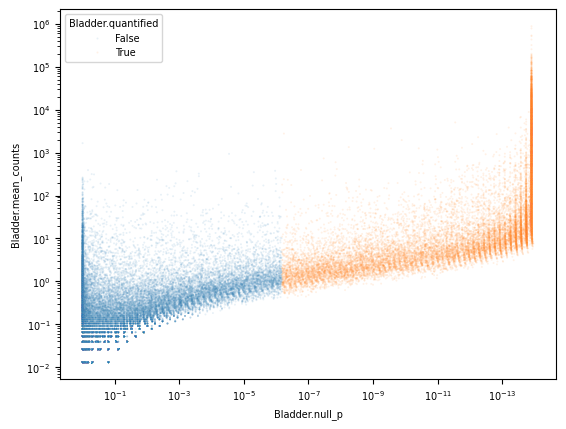

In [12]:
ax = sns.scatterplot(quantifications, x='Bladder.null_p', y='Bladder.mean_counts', hue='Bladder.quantified', alpha=.1, s=2)
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_yscale('log')

array(['Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)',
       'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary',
       'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex',
       'Brain - Frontal Cortex (BA9)', 'Brain - Hippocampus',
       'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)',
       'Brain - Spinal cord (cervical c-1)', 'Brain - Substantia nigra',
       'Breast - Mammary Tissue', 'Cells - Cultured fibroblasts',
       'Cells - EBV-transformed lymphocytes', 'Cervix - Ectocervix',
       'Cervix - Endocervix', 'Colon - Sigmoid', 'Colon - Transverse',
       'Colon - Transverse - Mixed Cell', 'Colon - Transverse - Mucosa',
       'Colon - Transverse - Muscularis',
       'Esophagus - Gastroesophageal Junction', 'Esophagus - 

In [ ]:
quantification_list = []
for tissue_id in tissue_sample_lists.index.values:
    quantifications = get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)
    quantification_list.append(quantifications.set_index('Name'))


	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Whole_Blood.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Frontal_Cortex_BA9.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Cerebellar_Hemisphere.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Substantia_nigra.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Anterior_cingulate_cortex_BA24.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Amygdala.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Caudate_basal_ganglia.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Nucleus_accumbens_basal_ganglia.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Putamen_basal_ganglia.v11.null_quantifications.txt
	/home/kla

  0%|          | 0/74590 [00:00<?, ?it/s]

KeyboardInterrupt: 